# Fitting the Brick 23 IR CMD

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# %config InlineBackend.figure_format='svg'

import os
import time
from glob import glob
import numpy as np

brick = 23
STARFISH = os.getenv("STARFISH")
isoc_dir = "b23ir_isoc"
lib_dir = "b23ir_lib"
synth_dir = "b23ir_synth"
fit_dir = "b23ir_fit"
wfc3_bands = ['F110W', 'F160W']

## Download Isochrones

We use a log-space age grid for ages less than a billion years, and a linear grid of every 0.5 Gyr thereafter.

In [2]:
from astropy.coordinates import Distance
import astropy.units as u

from padova import AgeGridRequest, IsochroneRequest
from starfisher import LibraryBuilder

z_grid = [0.012, 0.015, 0.019, 0.024, 0.03]
delta_gyr = 0.5
late_ages = np.log10(np.arange(1e9 + delta_gyr, 13e9, delta_gyr * 1e9))
print late_ages
if not os.path.exists(os.path.join(STARFISH, isoc_dir)):
    for z in z_grid:
        # Young ages in log-grid
        r = AgeGridRequest(z,
                           min_log_age=6.6,
                           max_log_age=9.,
                           delta_log_age=0.5,
                           phot='wfc3', photsys_version='odfnew')
        for isoc in r.isochrone_set:
            isoc.export_for_starfish(os.path.join(STARFISH, isoc_dir),
                                     bands=wfc3_bands)
        
        # Old ages in linear grid
        for logage in late_ages:
            r = IsochroneRequest(z, logage,
                                 phot='wfc3', photsys_version='odfnew')
            r.isochrone.export_for_starfish(os.path.join(STARFISH, isoc_dir),
                                     bands=wfc3_bands)

d = Distance(785 * u.kpc)
builder = LibraryBuilder(isoc_dir, lib_dir,
                         nmag=len(wfc3_bands),
                         dmod=d.distmod.value,
                         iverb=3)
if not os.path.exists(builder.full_isofile_path):
    builder.install()

[  9.           9.17609126   9.30103      9.39794001   9.47712125
   9.54406804   9.60205999   9.65321251   9.69897      9.74036269
   9.77815125   9.81291336   9.84509804   9.87506126   9.90308999
   9.92941893   9.95424251   9.97772361  10.          10.0211893
  10.04139269  10.06069784  10.07918125  10.09691001]


## Build the Isochrone Library and Synthesize CMD planes

In [3]:
from collections import namedtuple
from starfisher import Lockfile
from starfisher import Synth
from starfisher import ExtinctionDistribution
from starfisher import ExtantCrowdingTable
from starfisher import ColorPlane
from m31hst.phatast import PhatAstTable

if not os.path.exists(os.path.join(STARFISH, synth_dir)):
    os.makedirs(os.path.join(STARFISH, synth_dir))

# No binning in our lockfile
lockfile = Lockfile(builder.read_isofile(), synth_dir, unbinned=True)

# No extinction, yet
young_av = ExtinctionDistribution()
old_av = ExtinctionDistribution()
rel_extinction = np.ones(len(wfc3_bands), dtype=float)
for av in (young_av, old_av):
    av.set_uniform(0.)

# Use PHAT AST from the outer field
crowd_path = os.path.join(synth_dir, "crowding.dat")
full_crowd_path = os.path.join(STARFISH, crowd_path)
tbl = PhatAstTable()
tbl.write_crowdfile_for_field(full_crowd_path, 0)
crowd = ExtantCrowdingTable(crowd_path)

# Define CMD planes
Lim = namedtuple('Lim', 'x y')
ir_lim = Lim(x=(-1., 2.), y=(25., 16.))
ir_cmd = ColorPlane((wfc3_bands.index('F110W'),
                     wfc3_bands.index('F160W')),
                    wfc3_bands.index('F160W'),
                    ir_lim.x,
                    (min(ir_lim.y), max(ir_lim.y)),
                    28.,
                    suffix='f110f160',
                    x_label=r'$\mathrm{F110W}-\mathrm{F160W}$',
                    y_label=r'$\mathrm{F110W}$',
                   dpix=0.1)
colour_planes = [ir_cmd]

synth = Synth(synth_dir, builder, lockfile, crowd,
              rel_extinction,
              young_extinction=young_av,
              old_extinction=old_av,
              planes=colour_planes,
              mass_span=(0.08, 150.),
              nstars=10000000)
if len(glob(os.path.join(STARFISH, synth_dir, "z*"))) == 0:
    synth.run_synth(n_cpu=4)
    synth.plot_all_hess(os.path.join(STARFISH, synth_dir, 'hess'))

## Export the dataset for StarFISH

In [4]:
from astropy.table import Table
from m31hst import phat_v2_phot_path

if not os.path.exists(os.path.join(STARFISH, fit_dir)):
    os.makedirs(os.path.join(STARFISH, fit_dir))

data_root = os.path.join(fit_dir, "b23ir.")
full_data_path = os.path.join(STARFISH, '{0}f110f160'.format(data_root))
brick_table = Table.read(phat_v2_phot_path(brick), format='fits')

# Only use stars within the fitting box
c = brick_table['f110w_vega'] - brick_table['f160w_vega']
m = brick_table['f160w_vega']
sel = np.where((c > min(ir_lim.x)) & (c < max(ir_lim.x)) &
               (m > min(ir_lim.y)) & (m < max(ir_lim.y)))[0]
brick_table = brick_table[sel]

print("Fitting {0:d} stars".format(len(brick_table)))

if not os.path.exists(full_data_path):
    phot_dtype = np.dtype([('x', np.float), ('y', np.float)])
    photdata = np.empty(len(brick_table), dtype=phot_dtype)
    photdata['x'][:] = brick_table['f110w_vega'] - brick_table['f160w_vega']
    photdata['y'][:] = brick_table['f160w_vega']    
    np.savetxt(full_data_path, photdata, delimiter=' ', fmt='%.4f')

/Users/jsick/phat_data
Fitting 791266 stars


/Users/jsick/.virtualenvs/starfish/lib/python2.7/site-packages/matplotlib/contour.py:931: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')
/Users/jsick/.virtualenvs/starfish/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


{'origin': 'lower', 'extent': [-1.0, 2.0, 25.0, 16.0], 'vmin': None, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x10e5a7490>, 'aspect': 'auto', 'vmax': None, 'alpha': None, 'norm': None, 'interpolation': 'none'}


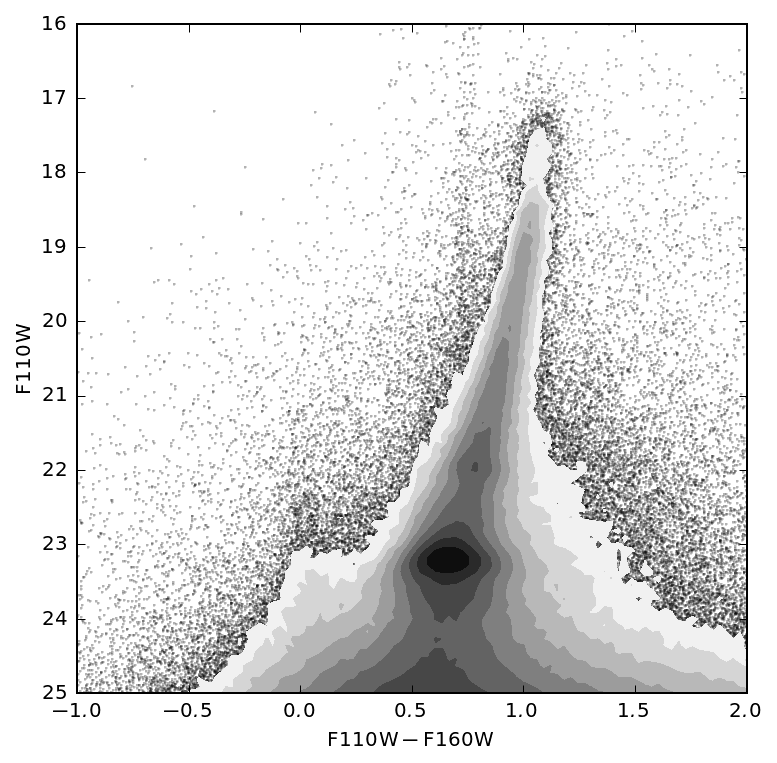

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from androcmd.plot import contour_hess

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
contour_hess(ax, brick_table['f110w_vega'] - brick_table['f160w_vega'],
             brick_table['f160w_vega'], ir_lim.x, (max(ir_lim.y), min(ir_lim.y)),
             plot_args={'ms': 3})
ir_cmd.plot_mask(ax)
ax.set_xlabel(r'$\mathrm{F110W}-\mathrm{F160W}$')
ax.set_ylabel(r'$\mathrm{F110W}$')
ax.set_xlim(ir_lim.x)
ax.set_ylim(ir_lim.y)
fig.show()

## Run StarFISH SFH

In [6]:
from starfisher import SFH, Mask

mask = Mask(colour_planes)
sfh = SFH(data_root, synth, mask, fit_dir)
if not os.path.exists(sfh.full_outfile_path):
    sfh.run_sfh()
sfh_table = sfh.solution_table()
print(sfh_table)

  Z   log(age)  amp_nstars ...        sfr         sfr_pos_err   sfr_neg_err  
                           ...     M_solar/yr      M_solar/yr    M_solar/yr  
----- -------- ----------- ... ----------------- ------------- --------------
0.012      6.6   821.39019 ...  0.00729322903297 7.16560219064 0.930689803811
0.012      7.1   811.37052 ...  0.00227818802454  2.3942768164 0.914410775149
0.012      7.6   277689.09 ...    0.246563710887 312.901046223  312.421164383
0.012      8.1   2061290.7 ...    0.578774760985 2317.69593438  2317.60150614
0.012      8.6   2492035.4 ...    0.221271025047 2801.66802966  2801.62142517
0.012      9.0   2382177.6 ...   0.0842062790663 2678.04724871  2678.05117998
0.012     9.18   49655.481 ...  0.00115967830778 55.8416999295  55.8232301541
0.012      9.3   5164561.1 ...   0.0914963480642 5806.07561155  5805.95642681
0.012      9.4   1581814.9 ...   0.0222600431848 1778.27044196  1778.27877975
0.012     9.48    49820.84 ... 0.000583151485267 56.0245417041  

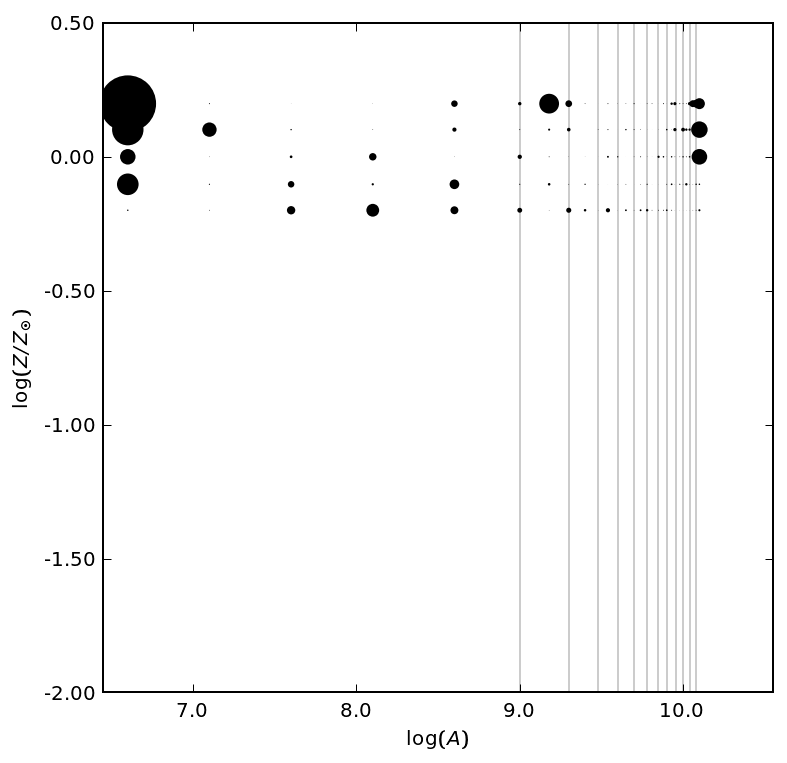

In [7]:
from starfisher.sfhplot import SFHCirclePlot

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

cp = SFHCirclePlot(sfh_table)
cp.plot_in_ax(ax, max_area=800)
for logage in np.log10(np.arange(1, 13, 1) * 1e9):
    ax.axvline(logage, c='0.8', zorder=-1)

fig.show()

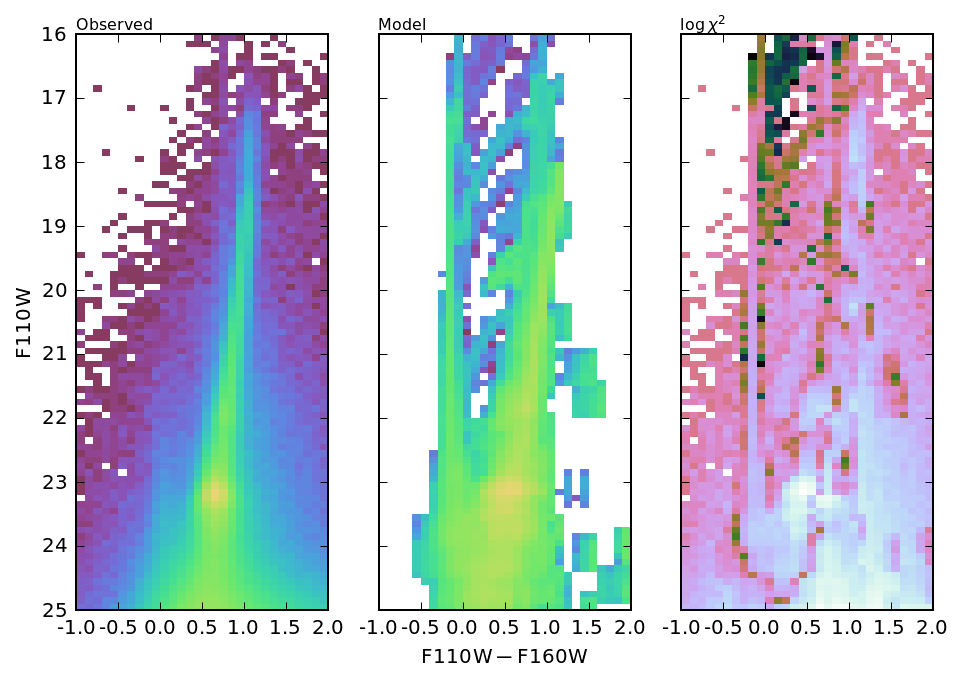

In [10]:
import cubehelix
cmapper = lambda: cubehelix.cmap(startHue=240,endHue=-300,minSat=1,maxSat=2.5,minLight=.3,maxLight=.8,gamma=.9)

from starfisher.sfhplot import ChiTriptykPlot
fig = plt.figure(figsize=(7, 5))
ctp = ChiTriptykPlot(sfh.full_chi_path, 1, ir_cmd.x_span, ir_cmd.y_span,
                     ir_cmd.dpix, ir_cmd.x_label, ir_cmd.y_label,
                    flipy=True)
ax_obs, ax_mod, ax_chi = ctp.setup_axes(fig)
ctp.plot_obs_in_ax(ax_obs, cmap=cmapper())
ctp.plot_mod_in_ax(ax_mod, cmap=cmapper())
ctp.plot_chi_in_ax(ax_chi, cmap=cubehelix.cmap())
ax_obs.text(0.0, 1.01, "Observed", transform=ax_obs.transAxes, size=8, ha='left')
ax_mod.text(0.0, 1.01, "Model", transform=ax_mod.transAxes, size=8, ha='left')
ax_chi.text(0.0, 1.01, r"$\log \chi^2$", transform=ax_chi.transAxes, size=8, ha='left')
fig.show()